# Autoencoder for image denoising

Problem

The calorimeter has a single shower where the energy is distributed through multiple blocks. The shower center can be anywhere in the calorimeter ( –1000 < x,y < +1000 ) and will never be outside of that. Energy from the shower that falls outside of the calorimeter however, is lost. 

Also here are additional noise hits. The challenge here is to remove that noise and produce a clean image. The two images above are the same event with noise. The one on the left however has been graphically enhanced to better show the noise.

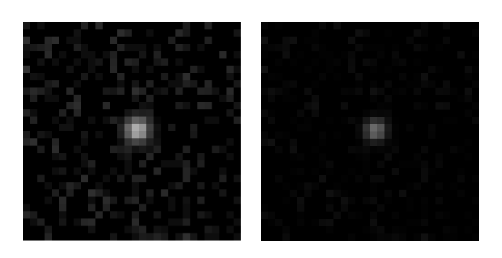

The data comes in a CSV file where the 900 energy deposition values are stored for both noisy and corresponding clean images. Hence there are 1800 pixel values per row, first 900 entries are for noisy image and later 900 entries represent pixel values of the corresponding clean image.

The problem has 3 data sets: train, test, judge.

The solution should be in the form of CSV files of the clean images. Each row should contain 900 pixel values (of 30x30 image) normalized between 0-1. The order of the entries should be in ascending order of the tailing numbers in the names of judge image files.  

In this case I think it is resonable to implement an autoencoder for image denoising, because deep neural networks are often quite good at taking big amounts of data and filtering through it to find answers and learn from data. 

Firstly let's import all necessary python libraries

In [25]:
import keras
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import MaxPooling2D, UpSampling2D
from keras.models import Model
import numpy as np
import pandas as pd
import cv2
from numpy import reshape
import matplotlib.pyplot as plt
from pathlib import Path
import os
from os import listdir
from os.path import isfile, join

Then get train and test datasets. CSV-file train_events.csv includes both noisy (first 900 columns) and clear data (last 900 columns), so we can split the noisy and clear data. Let's do it for train and test datasets

In [33]:
source = "https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem2/"

noisy_columns = [i for i in range(900)]
clear_columns = [i for i in range(900,1800)]

#train data

df_noisy = pd.read_csv(
    os.path.join(source,"train_events.csv"),usecols=noisy_columns, 
    na_values=['NA', '?'], header=None)

df_clear = pd.read_csv(
    os.path.join(source,"train_events.csv"),usecols=clear_columns, 
    na_values=['NA', '?'], header=None)

#test data
df_noisy_test = pd.read_csv(
    os.path.join(source,"test_events.csv"),usecols=noisy_columns, 
    na_values=['NA', '?'], header=None)

df_clear_test = pd.read_csv(
    os.path.join(source,"test_events.csv"),usecols=clear_columns, 
    na_values=['NA', '?'], header=None)

If we take a look on our dataframes we can see that both of them now consists of 900 columns

In [36]:
df_noisy.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.015686,0.000000,0.007843,0.000000,0.0,0.000000,0.000000,0.000000,0.031373,0.000000,...,0.000000,0.011765,0.062745,0.015686,0.000000,0.007843,0.007843,0.000000,0.000000,0.007843
1,0.011765,0.000000,0.007843,0.007843,0.0,0.000000,0.000000,0.011765,0.000000,0.000000,...,0.007843,0.000000,0.000000,0.027451,0.000000,0.000000,0.000000,0.007843,0.007843,0.050980
2,0.000000,0.019608,0.031373,0.000000,0.0,0.011765,0.027451,0.027451,0.000000,0.015686,...,0.000000,0.007843,0.000000,0.000000,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.007843,0.000000,0.000000,0.000000,0.0,0.000000,0.062745,0.000000,0.000000,0.000000,...,0.047059,0.007843,0.023529,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.007843,0.050980,0.000000,0.0,0.000000,0.000000,0.031373,0.000000,0.007843,...,0.000000,0.007843,0.031373,0.031373,0.000000,0.000000,0.011765,0.000000,0.007843,0.015686


In [31]:
df_clear_test.head()

,900,901,902,903,904,905,906,907,908,909,...,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's get judge dataset as well for the future purpose. It has information only about noisy images on the base of which we have to make a prediction or denoise the image in other words.

In [38]:
df_noisy_judge = pd.read_csv(
    os.path.join(source,"judge_events.csv"), 
    na_values=['NA', '?'], header=None)

df_noisy_judge.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.000000,0.000000,0.031373,0.027451,0.035294,0.000000,0.000000,0.015686,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.039216,0.007843,0.000000,0.0,0.000000,0.007843
1,0.000000,0.000000,0.000000,0.047059,0.000000,0.011765,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.023529,0.0,0.000000,0.027451,0.000000,0.0,0.000000,0.058824
2,0.047059,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.000000,0.039216,0.0,...,0.000000,0.000000,0.015686,0.0,0.000000,0.000000,0.000000,0.0,0.039216,0.007843
3,0.039216,0.031373,0.000000,0.011765,0.047059,0.031373,0.000000,0.007843,0.000000,0.0,...,0.000000,0.007843,0.031373,0.0,0.043137,0.007843,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.007843,0.047059,0.000000,0.000000,0.0,...,0.015686,0.000000,0.000000,0.0,0.000000,0.000000,0.035294,0.0,0.000000,0.015686


We have to use numpy arrays to feed the model, so let's make certain transformations

In [46]:
#train data
noisy_array = np.array(df_noisy).reshape((-1, 30, 30))
noisy_array = np.expand_dims(noisy_array, axis=-1) 

clear_array = np.array(df_clear).reshape((-1, 30, 30))
clear_array = np.expand_dims(clear_array, axis=-1)    

#test data
noisy_array_test = np.array(df_noisy_test).reshape((-1, 30, 30))
noisy_array_test = np.expand_dims(noisy_array_test, axis=-1) 

clear_array_test = np.array(df_clear_test).reshape((-1, 30, 30))
clear_array_test = np.expand_dims(clear_array_test, axis=-1) 

#judge data
noisy_array_judge = np.array(df_noisy_judge).reshape((-1, 30, 30))
noisy_array_judge = np.expand_dims(noisy_array_judge, axis=-1) 

print(f'The shape of noisy train array: {noisy_array.shape}')
print(f'The shape of clear train array: {clear_array.shape}')
print(f'The shape of noisy test array: {noisy_array_test.shape}')
print(f'The shape of clear test array: {clear_array_test.shape}')
print(f'The shape of noisy judge array: {noisy_array_judge.shape}')

The shape of noisy train array: (10000, 30, 30, 1)
The shape of clear train array: (10000, 30, 30, 1)
The shape of noisy test array: (2000, 30, 30, 1)
The shape of clear test array: (2000, 30, 30, 1)
The shape of noisy judge array: (2000, 30, 30, 1)


Next, we wish to build the encoder and decoder.

In [47]:
encoder_input = keras.Input(shape=(30,30,1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(64, activation = 'relu')(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(900, activation = 'relu')(encoder_output)
decoder_output = keras.layers.Reshape((30,30,1))(decoder_input)

opt = keras.optimizers.Adam(lr=0.001, decay = 1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 30, 30, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                57664     
_________________________________________________________________
dense_6 (Dense)              (None, 900)               58500     
_________________________________________________________________
reshape_3 (Reshape)          (None, 30, 30, 1)         0         
Total params: 116,164
Trainable params: 116,164
Non-trainable params: 0
_________________________________________________________________


This model does is take input of 30x30, flatten to a vector of 900 values, then go to a fully-connected dense layer of a mere 64 values. It means we've compressed to a mere 7% (64/900) of the original data. 

The "auto" part of this encoder is the dense neural network layer, and the weights/biases associated, which are going to be responsible for figuring out how to best compress these values.

The decoder's job is going to be to take this vector of 64 (at the moment) values and then "decompress" it back to the original image.

So this model will return to us the same shape of data, and we're hoping its a picture that is the same as our input was, which means our bottleneck of 64 values was a successful compression.

We'll now compile our model with the optimizer and a loss metric. We'll use mean squared error for loss (mse).

In [48]:
autoencoder.compile(opt, loss = 'mse')

Let's train our model with noisy and clear data. As a validation data we take the test noisy and clear arrays

In [50]:
autoencoder.fit(noisy_array, clear_array, epochs = 10, batch_size = 32, validation_data = (noisy_array_test, clear_array_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 56us/step - loss: 3.7985e-04 - val_loss: 3.6644e-04
Epoch 2/10
10000/10000 [==============================] - 1s 54us/step - loss: 3.7674e-04 - val_loss: 3.6377e-04
Epoch 3/10
10000/10000 [==============================] - 1s 53us/step - loss: 3.7514e-04 - val_loss: 3.6267e-04
Epoch 4/10
10000/10000 [==============================] - 1s 52us/step - loss: 3.7348e-04 - val_loss: 3.6025e-04
Epoch 5/10
10000/10000 [==============================] - 1s 53us/step - loss: 3.7163e-04 - val_loss: 3.5973e-04
Epoch 6/10
10000/10000 [==============================] - 1s 54us/step - loss: 3.7058e-04 - val_loss: 3.5878e-04
Epoch 7/10
10000/10000 [==============================] - 1s 53us/step - loss: 3.6945e-04 - val_loss: 3.5832e-04
Epoch 8/10
10000/10000 [==============================] - 1s 52us/step - loss: 3.6814e-04 - val_loss: 3.5717e-04
Epoch 9/10
10000/10000 [=======================

Now let's see what will be the output of the encoder model

In [53]:
example_test = encoder.predict([noisy_array_test[0].reshape(-1, 30, 30, 1)])[0]
example_test.shape

(64,)

We see the vector of 64 values which graphically looks like

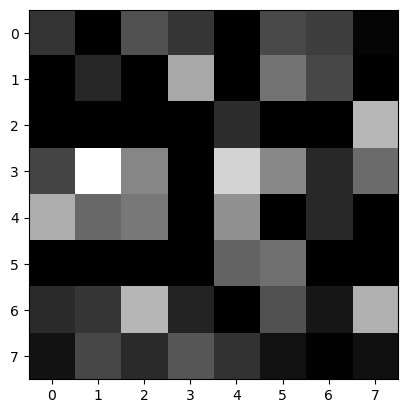

In [54]:
plt.imshow(example_test.reshape((8,8)), cmap = 'gray')

These values are not really  meaningfull for us, but it is interesting how the autoencoder works with prediction

The first noisy image from the test dataset is

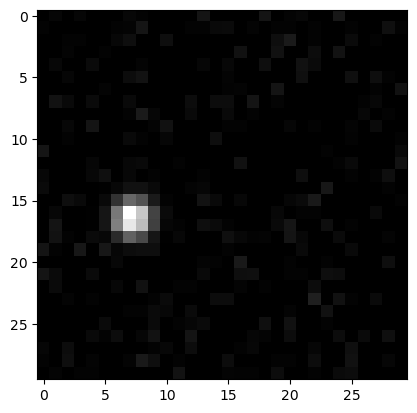

In [65]:
plt.imshow(noisy_array_test[0], cmap = 'gray')

The clear image that corresponds to it is

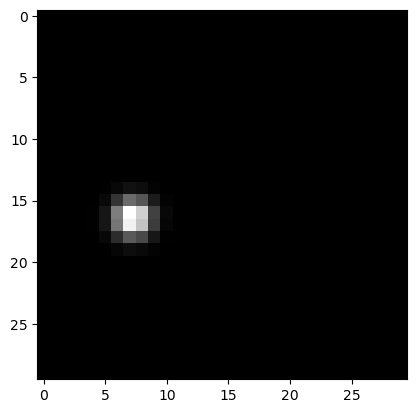

In [66]:
plt.imshow(clear_array_test[0], cmap = 'gray')

Now let's predict what the first test image after going through the autoencoder will look like.

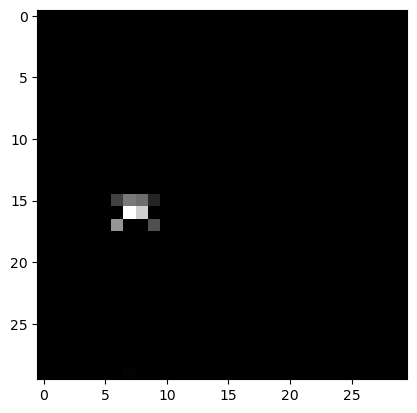

In [67]:
ae_out = autoencoder.predict([noisy_array_test[0].reshape(-1, 30, 30, 1)])[0]
plt.imshow(ae_out, cmap = 'gray')

It looks pretty similar I think.

Now we want to get predictions for the judge dataset. The shape of output is

In [76]:
ae_out_judge = autoencoder.predict([noisy_array_judge])
ae_out_judge.shape

(2000, 30, 30, 1)

We have to reshape the output to put it into the dataframe and then to csv-file

In [75]:
flatten_ae_out_judge = ae_out_judge.reshape(-1, 900,)
flatten_ae_out_judge.shape

(2000, 900)

Now we are able to create a dataframe and save as csv_file

In [80]:
path = "C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem2"
pd.DataFrame(flatten_ae_out_judge).to_csv(os.path.join(path,"output_judge.csv"),index=False,header=False)

If we read the created file we will see that we have 2000 rows by 900 values exactly what the judge dataset has. So for noisy judge data we got the clean data

In [82]:
df_output_judge = pd.read_csv(
    os.path.join(path,"output_judge.csv"),
    na_values=['NA', '?'], header=None)

df_output_judge

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
